In [3]:
from google.colab import drive
drive.mount('/content/drive')
root_path = '/content/drive/MyDrive/CSC2547/project'
 
import os
os.chdir(root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from model import Actor, Critic, DRRAveStateRepresentation, PMF
from learn import DRRTrainer
from utils.general import csv_plot
import torch
import pickle
import numpy as np
import random
import os
import datetime

import matplotlib.pyplot as plt
 
%matplotlib inline

In [23]:
 class config():
    output_path = 'results/' + datetime.datetime.now().strftime('%y%m%d-%H%M%S') + '/'
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plot_dir = output_path + 'rewards.pdf'
 
    train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
    train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
    train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'
 
    train_actor_loss_plot_dir = output_path + 'train_actor_loss.png'
    train_critic_loss_plot_dir = output_path + 'train_critic_loss.png'
    train_mean_reward_plot_dir = output_path + 'train_mean_reward.png'
 
    trained_models_dir = 'trained/'
 
    actor_model_trained = trained_models_dir + 'actor_net.weights'
    critic_model_trained = trained_models_dir + 'critic_net.weights'
    state_rep_model_trained = trained_models_dir + 'state_rep_net.weights'
 
    actor_model_dir = output_path + 'actor_net.weights'
    critic_model_dir = output_path + 'critic_net.weights'
    state_rep_model_dir = output_path + 'state_rep_net.weights'
 
    csv_dir = output_path + 'log.csv'
 
    path_to_trained_pmf = trained_models_dir + 'trained_pmf.pt'
 
    # hyperparams
    batch_size = 64
    gamma = 0.9
    replay_buffer_size = 100000
    history_buffer_size = 5
    learning_start = 5000
    learning_freq = 1
    lr_state_rep = 0.001
    lr_actor = 0.0001
    lr_critic = 0.001
    eps_start = 1
    eps = 0.1
    eps_steps = 10000
    eps_eval = 0.1
    tau = 0.01 # inital 0.001
    beta = 0.4
    prob_alpha = 0.3
    max_timesteps_train = 260000
    max_epochs_offline = 500
    max_timesteps_online = 20000
    embedding_feature_size = 100
    episode_length = 10
    train_ratio = 0.8
    weight_decay = 0.01
    clip_val = 1.0
    log_freq = 100
    saving_freq = 1000
    zero_reward = False
 
    no_cuda = False
 
def seed_all(cuda, seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.empty_cache()
        torch.cuda.manual_seed(seed=seed)
 
print("Initializing DRR Framework ----------------------------------------------------------------------------")
 
# Get CUDA device if available
cuda = True if not config.no_cuda and torch.cuda.is_available() else False
print("Using CUDA") if cuda else print("Using CPU")
 
 
# Init seeds
seed_all(cuda, 0)
print("Seeds initialized")
 
# Grab models
actor_function = Actor
critic_function = Critic
state_rep_function = DRRAveStateRepresentation
 
# Import Data
users = pickle.load(open('dataset/user_id_to_num.pkl', 'rb'))
items = pickle.load(open('dataset/rest_id_to_num.pkl', 'rb'))
data = np.load('dataset/data.npy')
 
# Normalize rewards to [-1, 1]
data[:, 1] = 0.5 * (data[:, 1] - 3)
 
np.random.shuffle(data)
train_data = torch.from_numpy(data[:int(config.train_ratio * data.shape[0])])
test_data = torch.from_numpy(data[int(config.train_ratio * data.shape[0]):])
print("Data imported, shuffled, and split into Train/Test, ratio=", config.train_ratio)
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)
 
# Create and load PMF function for rewards and embeddings
n_users = len(users)
n_items = len(items)
reward_function = PMF(n_users, n_items, config.embedding_feature_size, is_sparse=False, no_cuda=~cuda)
reward_function.load_state_dict(torch.load(config.path_to_trained_pmf))
 
# Freeze all the parameters in the network
for param in reward_function.parameters():
    param.requires_grad = False
print("Initialized PMF, imported weights, created reward_function")
 
# Extract embeddings
user_embeddings = reward_function.user_embeddings.weight.data
item_embeddings = reward_function.item_embeddings.weight.data
print("Extracted user and item embeddings from PMF")
print("User embeddings shape: ", user_embeddings.shape)
print("Item embeddings shape: ", item_embeddings.shape)
 
# Init trainer
print("Initializing DRRTrainer -------------------------------------------------------------------------------")
trainer = DRRTrainer(config,
                      actor_function,
                      critic_function,
                      state_rep_function,
                      reward_function,
                      users,
                      items,
                      train_data,
                      test_data,
                      user_embeddings,
                      item_embeddings,
                      cuda
                      )
 
# Train
# print("Starting DRRTrainer.learn() ---------------------------------------------------------------------------")
# actor_losses, critic_losses, epi_avg_rewards = trainer.learn()

Initializing DRR Framework ----------------------------------------------------------------------------
Using CUDA
Seeds initialized
Data imported, shuffled, and split into Train/Test, ratio= 0.8
Train data shape:  torch.Size([4460266, 5])
Test data shape:  torch.Size([1115067, 5])
Initialized PMF, imported weights, created reward_function
Extracted user and item embeddings from PMF
User embeddings shape:  torch.Size([2189437, 100])
Item embeddings shape:  torch.Size([50793, 100])
Initializing DRRTrainer -------------------------------------------------------------------------------
CUDA Device ID:  0
Tesla V100-SXM2-16GB
CUDA Memory Allocated:  0
CUDA Memory Reserved:  0.920649728 GB
Current PyTorch Device:  cuda:0
Data dimensions extracted
Models initialized
Model weights initialized, copied to target
All models, train data, and user embeddings data moved to CUDA
Optimizers initialized


In [24]:
# Change to newest trained data directories
# config.trained_models_dir = config.output_path
# output_path = config.output_path
config.trained_models_dir = "results/210419-181221/"
output_path = "results/210419-181221/"

train_actor_loss_data_dir = output_path + 'train_actor_loss_data.npy'
train_critic_loss_data_dir = output_path + 'train_critic_loss_data.npy'
train_mean_reward_data_dir = output_path + 'train_mean_reward_data.npy'

config.actor_model_trained = config.trained_models_dir + 'actor_net.weights'
config.critic_model_trained = config.trained_models_dir + 'critic_net.weights'
config.state_rep_model_trained = config.trained_models_dir + 'state_rep_net.weights'

Create and save smoothened graphs of losses and average rewards for training

In [7]:
!pip install tsmoothie

def noiseless_plot(y, title, ylabel, save_loc):
  # operate smoothing
  smoother = ConvolutionSmoother(window_len=1000, window_type='ones')
  smoother.smooth(y)

  # generate intervals
  low, up = smoother.get_intervals('sigma_interval', n_sigma=3)

  # plot the smoothed timeseries with intervals
  plt.close()
  plt.figure(figsize=(11,6))
  plt.xlabel("Epoch")
  plt.ylabel(ylabel)
  plt.title(title)
  plt.plot(smoother.data[0], color='orange')
  plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
  plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)
  plt.savefig(save_loc)
  plt.close()

In [ ]:
import matplotlib.pyplot as plt
from tsmoothie.smoother import *

actor_losses = np.load(train_actor_loss_data_dir)
critic_losses = np.load(train_critic_loss_data_dir)
epi_avg_rewards = np.load(train_mean_reward_data_dir)

noiseless_plot(actor_losses, 
               "Actor Loss (Train)", 
               "Actor Loss (Train)", 
               output_path + "train_actor_loss_smooth.png")
               
noiseless_plot(critic_losses, 
               "Critic Loss (Train)", 
               "Critic Loss (Train)", 
               output_path + "train_critic_loss_smooth.png")

noiseless_plot(epi_avg_rewards, 
               "Mean Reward (Train)", 
               "Mean Reward (Train)", 
               output_path + "train_mean_reward_smooth.png")

Save hyperparameters.

In [ ]:
sourceFile = open(output_path + "hyperparams.txt", 'w')
print(config.__dict__, file = sourceFile)
sourceFile.close()

**Run** Offline and Online evaluations, save scores.

In [14]:
T_precisions = [5, 10, 15, 20]

Episode 20 | Precision@5 0.8 | Avg Precision@5 0.7400 | 
Episode 40 | Precision@5 0.8 | Avg Precision@5 0.7150 | 
Episode 60 | Precision@5 0.8 | Avg Precision@5 0.7400 | 
Episode 80 | Precision@5 0.8 | Avg Precision@5 0.7250 | 
Episode 100 | Precision@5 0.8 | Avg Precision@5 0.7240 | 
Episode 120 | Precision@5 0.8 | Avg Precision@5 0.7200 | 
Episode 140 | Precision@5 1.0 | Avg Precision@5 0.7257 | 
Episode 160 | Precision@5 0.6 | Avg Precision@5 0.7275 | 
Episode 180 | Precision@5 0.6 | Avg Precision@5 0.7256 | 
Episode 200 | Precision@5 0.4 | Avg Precision@5 0.7250 | 
Episode 220 | Precision@5 0.8 | Avg Precision@5 0.7245 | 
Episode 240 | Precision@5 1.0 | Avg Precision@5 0.7242 | 
Episode 260 | Precision@5 1.0 | Avg Precision@5 0.7277 | 
Episode 280 | Precision@5 0.8 | Avg Precision@5 0.7321 | 
Episode 300 | Precision@5 0.6 | Avg Precision@5 0.7320 | 
Episode 320 | Precision@5 1.0 | Avg Precision@5 0.7312 | 
Episode 340 | Precision@5 0.8 | Avg Precision@5 0.7329 | 
Episode 360 | Prec

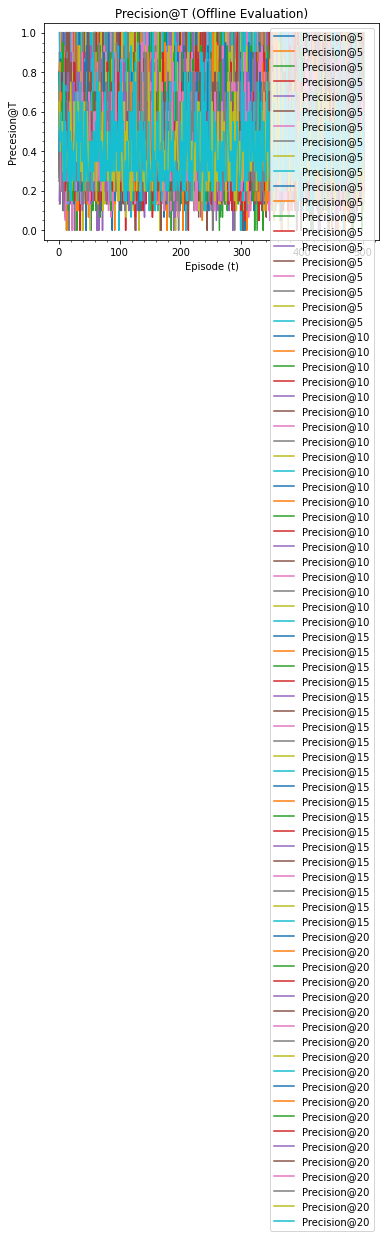

In [25]:
# Offline evaluate

# PMF
for T_precision in T_precisions:
  pmf_Ts = []
  for i in range(20):
    # Evaluate
    avg_precision = trainer.offline_pmf_evaluate(T_precision)

    # Append to list
    pmf_Ts.append(avg_precision)

  # Save data
  pmf_Ts = np.array(pmf_Ts)
  np.save(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.npy', pmf_Ts)

  # Save
  sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_pmf_eval.txt', 'w')
  print(f'Average Precision@{T_precision} (Eval): {np.mean(pmf_Ts)}', file=sourceFile)
  sourceFile.close()

# DRR
# for T_precision in T_precisions:
#   drr_Ts = []
#   for i in range(20):
#     # Evaluate
#     avg_precision = trainer.offline_evaluate(T_precision)

#     # Append to list
#     drr_Ts.append(avg_precision)

#   # Save data
#   drr_Ts = np.array(drr_Ts)
#   np.save(output_path + f'avg_precision@{T_precision}_offline_eval.npy', drr_Ts)

#   # Save
#   sourceFile = open(output_path + f'avg_precision@{T_precision}_offline_eval.txt', 'w')
#   print(f'Average Precision@{T_precision} (Eval): {np.mean(drr_Ts)}', file=sourceFile)
#   sourceFile.close()

In [26]:
pmf_fives = np.load(output_path + 'avg_precision@5_offline_pmf_eval.npy')
pmf_tens = np.load(output_path + 'avg_precision@10_offline_pmf_eval.npy')
pmf_fifteens = np.load(output_path + 'avg_precision@15_offline_pmf_eval.npy')
pmf_twenties = np.load(output_path + 'avg_precision@20_offline_pmf_eval.npy')

drr_fives = np.load(output_path + 'avg_precision@5_offline_eval.npy')
drr_tens = np.load(output_path + 'avg_precision@10_offline_eval.npy')
drr_fifteens = np.load(output_path + 'avg_precision@15_offline_eval.npy')
drr_twenties = np.load(output_path + 'avg_precision@20_offline_eval.npy')

In [13]:
Ts = [5, 10, 15, 20]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6594 | Critic Params Norm 3.2874 | Actor Loss -7.9053 | Critic Loss 0.0647 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6337 | Critic Params Norm 2.5251 | Actor Loss -7.8517 | Critic Loss 0.0591 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.7064 | Critic Params Norm 2.4499 | Actor Loss -9.1687 | Critic Loss 0.0853 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6790 | Critic Params Norm 3.5123 | Actor Loss -8.7525 | Critic Loss 0.0485 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6546 | Critic Params Norm 4.8795 | Actor Loss -8.1816 | Critic Loss 0.0526 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6403 | Critic Params Norm 4.7016 | Actor Loss -7.9548 | Critic Loss 0.0583 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6393 | Critic Params Norm 4.3722 | Actor Loss -8.0552 | Critic Loss 0.0702 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6312 | Critic Params Norm 5.1471 | Actor Loss -7.8287 | Critic Loss 0.0680

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6570 | Critic Params Norm 7.0655 | Actor Loss -7.7542 | Critic Loss 0.0594 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6517 | Critic Params Norm 4.0975 | Actor Loss -8.3338 | Critic Loss 0.0402 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6245 | Critic Params Norm 3.3263 | Actor Loss -7.6796 | Critic Loss 0.0676 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6347 | Critic Params Norm 5.3362 | Actor Loss -6.7602 | Critic Loss 0.0861 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6129 | Critic Params Norm 3.4569 | Actor Loss -6.6210 | Critic Loss 0.0667 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.5860 | Critic Params Norm 11.0696 | Actor Loss -6.4007 | Critic Loss 0.0711 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.5914 | Critic Params Norm 3.5130 | Actor Loss -7.4109 | Critic Loss 0.0490 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.5723 | Critic Params Norm 4.1501 | Actor Loss -6.5124 | Critic Loss 0.063

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5874 | Critic Params Norm 5.1946 | Actor Loss -7.8195 | Critic Loss 0.0460 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6010 | Critic Params Norm 7.1281 | Actor Loss -6.9616 | Critic Loss 0.0605 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6153 | Critic Params Norm 5.5799 | Actor Loss -6.7425 | Critic Loss 0.0502 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6055 | Critic Params Norm 7.8214 | Actor Loss -7.1927 | Critic Loss 0.0484 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6024 | Critic Params Norm 6.1146 | Actor Loss -7.6475 | Critic Loss 0.0776 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6093 | Critic Params Norm 4.5466 | Actor Loss -7.2128 | Critic Loss 0.0501 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6078 | Critic Params Norm 6.8373 | Actor Loss -7.6086 | Critic Loss 0.0839 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6185 | Critic Params Norm 8.6946 | Actor Loss -7.1728 | Critic Loss 0.0629

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5893 | Critic Params Norm 4.7226 | Actor Loss -7.4105 | Critic Loss 0.0505 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6116 | Critic Params Norm 9.4401 | Actor Loss -7.1903 | Critic Loss 0.0634 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6215 | Critic Params Norm 6.7427 | Actor Loss -7.7704 | Critic Loss 0.0714 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5933 | Critic Params Norm 7.1944 | Actor Loss -7.3771 | Critic Loss 0.0550 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6200 | Critic Params Norm 8.9926 | Actor Loss -7.6446 | Critic Loss 0.0767 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6347 | Critic Params Norm 7.5347 | Actor Loss -7.9536 | Critic Loss 0.0619 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6476 | Critic Params Norm 5.8761 | Actor Loss -7.3515 | Critic Loss 0.0778 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6363 | Critic Params Norm 3.8547 | Actor Loss -7.4381 | Critic Loss 0.0520

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5987 | Critic Params Norm 3.0737 | Actor Loss -7.4410 | Critic Loss 0.0833 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6404 | Critic Params Norm 1.8392 | Actor Loss -8.2124 | Critic Loss 0.0495 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6179 | Critic Params Norm 11.6536 | Actor Loss -7.8518 | Critic Loss 0.1130 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6099 | Critic Params Norm 1.5457 | Actor Loss -7.5644 | Critic Loss 0.0699 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6246 | Critic Params Norm 3.2657 | Actor Loss -8.1491 | Critic Loss 0.0581 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6369 | Critic Params Norm 5.9825 | Actor Loss -7.0554 | Critic Loss 0.0735 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6314 | Critic Params Norm 4.1297 | Actor Loss -7.2523 | Critic Loss 0.0405 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6384 | Critic Params Norm 9.4678 | Actor Loss -6.7360 | Critic Loss 0.093

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6259 | Critic Params Norm 4.2978 | Actor Loss -7.2087 | Critic Loss 0.0981 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6293 | Critic Params Norm 9.4747 | Actor Loss -7.0370 | Critic Loss 0.1158 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6108 | Critic Params Norm 2.0891 | Actor Loss -8.1145 | Critic Loss 0.0373 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6286 | Critic Params Norm 2.4883 | Actor Loss -8.3800 | Critic Loss 0.0772 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6422 | Critic Params Norm 6.0631 | Actor Loss -7.4419 | Critic Loss 0.0628 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6463 | Critic Params Norm 9.1567 | Actor Loss -7.4128 | Critic Loss 0.1124 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6531 | Critic Params Norm 10.1463 | Actor Loss -6.9737 | Critic Loss 0.0657 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6517 | Critic Params Norm 2.4952 | Actor Loss -7.9065 | Critic Loss 0.061

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6098 | Critic Params Norm 14.3685 | Actor Loss -7.7150 | Critic Loss 0.1304 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6771 | Critic Params Norm 5.2466 | Actor Loss -8.3452 | Critic Loss 0.0619 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6956 | Critic Params Norm 8.4883 | Actor Loss -7.8644 | Critic Loss 0.0877 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6876 | Critic Params Norm 3.7409 | Actor Loss -8.3697 | Critic Loss 0.0448 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6536 | Critic Params Norm 6.2124 | Actor Loss -8.3725 | Critic Loss 0.0664 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6442 | Critic Params Norm 6.1172 | Actor Loss -7.7288 | Critic Loss 0.0680 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6210 | Critic Params Norm 8.6190 | Actor Loss -7.7168 | Critic Loss 0.0790 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6243 | Critic Params Norm 5.6643 | Actor Loss -7.5445 | Critic Loss 0.083

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6195 | Critic Params Norm 4.6601 | Actor Loss -7.4770 | Critic Loss 0.0679 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6683 | Critic Params Norm 4.8295 | Actor Loss -8.6208 | Critic Loss 0.0711 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6536 | Critic Params Norm 3.1047 | Actor Loss -7.6940 | Critic Loss 0.0408 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6518 | Critic Params Norm 5.8347 | Actor Loss -7.7607 | Critic Loss 0.0647 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6413 | Critic Params Norm 5.0056 | Actor Loss -7.6148 | Critic Loss 0.0425 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6174 | Critic Params Norm 5.7336 | Actor Loss -6.9654 | Critic Loss 0.0747 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6204 | Critic Params Norm 6.9510 | Actor Loss -7.2010 | Critic Loss 0.0615 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6251 | Critic Params Norm 8.4259 | Actor Loss -7.0657 | Critic Loss 0.0788

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5245 | Critic Params Norm 7.5842 | Actor Loss -6.9073 | Critic Loss 0.0946 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6503 | Critic Params Norm 1.7840 | Actor Loss -7.9910 | Critic Loss 0.0614 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6534 | Critic Params Norm 4.2162 | Actor Loss -7.6220 | Critic Loss 0.0621 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6442 | Critic Params Norm 5.8265 | Actor Loss -7.2285 | Critic Loss 0.0466 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6163 | Critic Params Norm 5.8552 | Actor Loss -6.9975 | Critic Loss 0.0860 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6154 | Critic Params Norm 11.7289 | Actor Loss -7.4053 | Critic Loss 0.0778 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6119 | Critic Params Norm 1.5413 | Actor Loss -7.8897 | Critic Loss 0.0697 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6270 | Critic Params Norm 2.0565 | Actor Loss -7.5065 | Critic Loss 0.053

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.7346 | Critic Params Norm 3.0972 | Actor Loss -8.4455 | Critic Loss 0.0611 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6762 | Critic Params Norm 3.5220 | Actor Loss -8.3197 | Critic Loss 0.0347 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6867 | Critic Params Norm 8.2871 | Actor Loss -7.3421 | Critic Loss 0.0936 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6990 | Critic Params Norm 8.7399 | Actor Loss -8.1724 | Critic Loss 0.0814 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.7053 | Critic Params Norm 4.6783 | Actor Loss -7.8988 | Critic Loss 0.0539 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6829 | Critic Params Norm 3.6530 | Actor Loss -8.2672 | Critic Loss 0.0659 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6689 | Critic Params Norm 3.5852 | Actor Loss -8.2227 | Critic Loss 0.0514 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6626 | Critic Params Norm 5.0321 | Actor Loss -7.4343 | Critic Loss 0.0548

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.7251 | Critic Params Norm 1.6098 | Actor Loss -7.5538 | Critic Loss 0.0320 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6114 | Critic Params Norm 3.6734 | Actor Loss -7.2226 | Critic Loss 0.0428 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.5956 | Critic Params Norm 1.8662 | Actor Loss -7.7855 | Critic Loss 0.0342 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6286 | Critic Params Norm 1.2992 | Actor Loss -7.6279 | Critic Loss 0.0517 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6234 | Critic Params Norm 6.2723 | Actor Loss -7.0891 | Critic Loss 0.0628 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6211 | Critic Params Norm 5.2520 | Actor Loss -7.5200 | Critic Loss 0.0731 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6445 | Critic Params Norm 5.3976 | Actor Loss -7.4612 | Critic Loss 0.0371 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6515 | Critic Params Norm 2.6701 | Actor Loss -8.6022 | Critic Loss 0.0670

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6045 | Critic Params Norm 4.1648 | Actor Loss -7.0655 | Critic Loss 0.0573 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6362 | Critic Params Norm 4.9148 | Actor Loss -7.4161 | Critic Loss 0.0479 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.5815 | Critic Params Norm 7.2819 | Actor Loss -6.5847 | Critic Loss 0.0694 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5883 | Critic Params Norm 4.4715 | Actor Loss -7.1951 | Critic Loss 0.0402 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6108 | Critic Params Norm 5.8317 | Actor Loss -7.3876 | Critic Loss 0.0476 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.5866 | Critic Params Norm 6.0278 | Actor Loss -7.3127 | Critic Loss 0.0487 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.5795 | Critic Params Norm 9.6996 | Actor Loss -7.0013 | Critic Loss 0.0598 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.5844 | Critic Params Norm 9.7412 | Actor Loss -7.4136 | Critic Loss 0.0946

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6858 | Critic Params Norm 4.5450 | Actor Loss -8.2426 | Critic Loss 0.0344 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6474 | Critic Params Norm 3.5217 | Actor Loss -8.7389 | Critic Loss 0.0449 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6585 | Critic Params Norm 1.3193 | Actor Loss -8.5808 | Critic Loss 0.0435 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6497 | Critic Params Norm 13.2051 | Actor Loss -7.1236 | Critic Loss 0.1060 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6525 | Critic Params Norm 7.6065 | Actor Loss -7.6401 | Critic Loss 0.0825 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6520 | Critic Params Norm 6.6214 | Actor Loss -7.9534 | Critic Loss 0.0637 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6465 | Critic Params Norm 4.6382 | Actor Loss -7.3338 | Critic Loss 0.0485 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6268 | Critic Params Norm 2.7966 | Actor Loss -7.5815 | Critic Loss 0.062

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6911 | Critic Params Norm 2.5573 | Actor Loss -7.2968 | Critic Loss 0.0286 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.5956 | Critic Params Norm 11.3729 | Actor Loss -7.1483 | Critic Loss 0.0915 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6113 | Critic Params Norm 7.6631 | Actor Loss -7.8582 | Critic Loss 0.0657 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5726 | Critic Params Norm 7.0821 | Actor Loss -7.5253 | Critic Loss 0.0546 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.5929 | Critic Params Norm 9.5294 | Actor Loss -7.7418 | Critic Loss 0.0721 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6280 | Critic Params Norm 2.7787 | Actor Loss -7.9183 | Critic Loss 0.0442 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6460 | Critic Params Norm 7.8368 | Actor Loss -7.6297 | Critic Loss 0.0620 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6400 | Critic Params Norm 10.2706 | Actor Loss -7.3484 | Critic Loss 0.06

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5453 | Critic Params Norm 7.3168 | Actor Loss -7.1610 | Critic Loss 0.0715 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.5372 | Critic Params Norm 9.5500 | Actor Loss -6.8730 | Critic Loss 0.0554 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.5537 | Critic Params Norm 8.0150 | Actor Loss -6.8037 | Critic Loss 0.0619 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5744 | Critic Params Norm 6.6323 | Actor Loss -7.2615 | Critic Loss 0.0897 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6031 | Critic Params Norm 8.1147 | Actor Loss -7.3246 | Critic Loss 0.0853 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6021 | Critic Params Norm 3.9754 | Actor Loss -7.9762 | Critic Loss 0.0479 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6095 | Critic Params Norm 4.6711 | Actor Loss -7.1533 | Critic Loss 0.0458 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6089 | Critic Params Norm 6.2523 | Actor Loss -7.3386 | Critic Loss 0.0610

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.6077 | Critic Params Norm 6.1477 | Actor Loss -6.7478 | Critic Loss 0.0608 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6009 | Critic Params Norm 5.9753 | Actor Loss -7.5139 | Critic Loss 0.0491 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6010 | Critic Params Norm 4.2761 | Actor Loss -8.1644 | Critic Loss 0.0581 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5899 | Critic Params Norm 2.7540 | Actor Loss -7.7380 | Critic Loss 0.0430 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6116 | Critic Params Norm 4.0787 | Actor Loss -7.8652 | Critic Loss 0.0492 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6110 | Critic Params Norm 5.5309 | Actor Loss -7.6959 | Critic Loss 0.0443 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6249 | Critic Params Norm 12.7335 | Actor Loss -6.0010 | Critic Loss 0.0947 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6343 | Critic Params Norm 3.0252 | Actor Loss -7.6591 | Critic Loss 0.038

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5715 | Critic Params Norm 3.4564 | Actor Loss -7.7905 | Critic Loss 0.0419 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6333 | Critic Params Norm 4.3258 | Actor Loss -8.0276 | Critic Loss 0.0592 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6282 | Critic Params Norm 9.0943 | Actor Loss -7.3388 | Critic Loss 0.1002 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6561 | Critic Params Norm 4.9613 | Actor Loss -7.4226 | Critic Loss 0.0550 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6610 | Critic Params Norm 5.5689 | Actor Loss -7.9648 | Critic Loss 0.0858 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6432 | Critic Params Norm 7.6798 | Actor Loss -7.5671 | Critic Loss 0.0785 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6268 | Critic Params Norm 4.7129 | Actor Loss -7.7863 | Critic Loss 0.0697 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6122 | Critic Params Norm 5.4777 | Actor Loss -7.5188 | Critic Loss 0.0546

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.7353 | Critic Params Norm 4.3914 | Actor Loss -8.5239 | Critic Loss 0.0652 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6688 | Critic Params Norm 6.7816 | Actor Loss -7.7405 | Critic Loss 0.0771 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6585 | Critic Params Norm 2.5553 | Actor Loss -8.1466 | Critic Loss 0.0611 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6533 | Critic Params Norm 4.7961 | Actor Loss -7.5855 | Critic Loss 0.0551 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6313 | Critic Params Norm 6.4446 | Actor Loss -7.4783 | Critic Loss 0.0600 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6232 | Critic Params Norm 6.2455 | Actor Loss -7.4579 | Critic Loss 0.0506 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6126 | Critic Params Norm 7.0681 | Actor Loss -7.4452 | Critic Loss 0.0704 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.5985 | Critic Params Norm 7.6002 | Actor Loss -6.8856 | Critic Loss 0.0722

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 20 | Avg Total Reward 0.6856 | Critic Params Norm 6.8968 | Actor Loss -7.4044 | Critic Loss 0.0574 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.6650 | Critic Params Norm 7.7451 | Actor Loss -7.7268 | Critic Loss 0.0987 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6897 | Critic Params Norm 3.4907 | Actor Loss -8.3153 | Critic Loss 0.0605 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.6471 | Critic Params Norm 8.6043 | Actor Loss -7.3331 | Critic Loss 0.0803 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.6319 | Critic Params Norm 5.9822 | Actor Loss -7.4407 | Critic Loss 0.0600 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.6353 | Critic Params Norm 5.1346 | Actor Loss -8.1778 | Critic Loss 0.0705 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.6314 | Critic Params Norm 6.9064 | Actor Loss -7.4442 | Critic Loss 0.0786 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.6094 | Critic Params Norm 9.8800 | Actor Loss -6.9540 | Critic Loss 0.0797

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 20 | Avg Total Reward 0.5013 | Critic Params Norm 4.7544 | Actor Loss -6.9571 | Critic Loss 0.0386 | 
Timestep 200 | Episode 40 | Avg Total Reward 0.5875 | Critic Params Norm 5.9048 | Actor Loss -7.0469 | Critic Loss 0.0686 | 
Timestep 300 | Episode 60 | Avg Total Reward 0.6087 | Critic Params Norm 7.8684 | Actor Loss -7.1413 | Critic Loss 0.0684 | 
Timestep 400 | Episode 80 | Avg Total Reward 0.5798 | Critic Params Norm 4.6636 | Actor Loss -7.5051 | Critic Loss 0.0516 | 
Timestep 500 | Episode 100 | Avg Total Reward 0.5727 | Critic Params Norm 1.8197 | Actor Loss -7.6114 | Critic Loss 0.0478 | 
Timestep 600 | Episode 120 | Avg Total Reward 0.5771 | Critic Params Norm 9.9495 | Actor Loss -6.8224 | Critic Loss 0.0812 | 
Timestep 700 | Episode 140 | Avg Total Reward 0.5802 | Critic Params Norm 5.0973 | Actor Loss -7.4202 | Critic Loss 0.0584 | 
Timestep 800 | Episode 160 | Avg Total Reward 0.5864 | Critic Params Norm 5.1899 | Actor Loss -7.5838 | Critic Loss 0.0826

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.7416 | Critic Params Norm 3.3723 | Actor Loss -7.7199 | Critic Loss 0.0507 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.7122 | Critic Params Norm 5.2492 | Actor Loss -6.9732 | Critic Loss 0.0528 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6799 | Critic Params Norm 3.0127 | Actor Loss -7.3102 | Critic Loss 0.0365 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6450 | Critic Params Norm 6.7726 | Actor Loss -6.6318 | Critic Loss 0.0518 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6110 | Critic Params Norm 6.4475 | Actor Loss -6.7043 | Critic Loss 0.0558 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6175 | Critic Params Norm 5.8872 | Actor Loss -6.4490 | Critic Loss 0.0464 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6021 | Critic Params Norm 10.7207 | Actor Loss -6.4515 | Critic Loss 0.0538 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6048 | Critic Params Norm 5.1063 | Actor Loss -6.0419 | Critic Loss 0.0545 | 

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 10 | Avg Total Reward 0.7649 | Critic Params Norm 4.1106 | Actor Loss -8.6603 | Critic Loss 0.0370 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6854 | Critic Params Norm 6.9886 | Actor Loss -7.3786 | Critic Loss 0.0319 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6504 | Critic Params Norm 7.3117 | Actor Loss -7.6098 | Critic Loss 0.0471 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6561 | Critic Params Norm 6.9518 | Actor Loss -7.6644 | Critic Loss 0.0476 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6454 | Critic Params Norm 7.5809 | Actor Loss -7.3159 | Critic Loss 0.0467 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6513 | Critic Params Norm 7.3359 | Actor Loss -7.1020 | Critic Loss 0.0435 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6524 | Critic Params Norm 9.1834 | Actor Loss -7.4884 | Critic Loss 0.0492 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6553 | Critic Params Norm 8.9465 | Actor Loss -7.0089 | Critic Loss 0.0595 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.5280 | Critic Params Norm 12.0322 | Actor Loss -6.7849 | Critic Loss 0.0623 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5534 | Critic Params Norm 9.8683 | Actor Loss -6.7552 | Critic Loss 0.0398 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6310 | Critic Params Norm 9.2158 | Actor Loss -7.4428 | Critic Loss 0.0445 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6292 | Critic Params Norm 8.7193 | Actor Loss -7.2516 | Critic Loss 0.0558 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6384 | Critic Params Norm 8.1789 | Actor Loss -7.2540 | Critic Loss 0.0554 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6688 | Critic Params Norm 11.3905 | Actor Loss -7.6689 | Critic Loss 0.0759 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6878 | Critic Params Norm 10.6786 | Actor Loss -8.4768 | Critic Loss 0.0622 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6702 | Critic Params Norm 3.2956 | Actor Loss -7.6621 | Critic Loss 0.0349 

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 10 | Avg Total Reward 0.6450 | Critic Params Norm 5.0340 | Actor Loss -7.0984 | Critic Loss 0.0532 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.7064 | Critic Params Norm 3.6288 | Actor Loss -8.4709 | Critic Loss 0.0505 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.7269 | Critic Params Norm 7.1805 | Actor Loss -7.6547 | Critic Loss 0.0333 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.7387 | Critic Params Norm 8.5177 | Actor Loss -7.7730 | Critic Loss 0.0585 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6925 | Critic Params Norm 8.3239 | Actor Loss -7.6605 | Critic Loss 0.0774 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6972 | Critic Params Norm 5.9077 | Actor Loss -7.4538 | Critic Loss 0.0395 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6492 | Critic Params Norm 7.3076 | Actor Loss -6.7610 | Critic Loss 0.0673 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6376 | Critic Params Norm 13.2836 | Actor Loss -6.7566 | Critic Loss 0.0745 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.5438 | Critic Params Norm 8.1036 | Actor Loss -6.5379 | Critic Loss 0.0539 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6026 | Critic Params Norm 6.0624 | Actor Loss -6.9606 | Critic Loss 0.0561 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6332 | Critic Params Norm 4.8071 | Actor Loss -7.3070 | Critic Loss 0.0465 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6195 | Critic Params Norm 11.8210 | Actor Loss -6.8150 | Critic Loss 0.0671 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6282 | Critic Params Norm 9.0078 | Actor Loss -7.9977 | Critic Loss 0.0563 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6360 | Critic Params Norm 5.1305 | Actor Loss -7.9103 | Critic Loss 0.0560 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6356 | Critic Params Norm 6.0426 | Actor Loss -7.8048 | Critic Loss 0.0481 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6383 | Critic Params Norm 7.1250 | Actor Loss -7.2293 | Critic Loss 0.0488 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.6351 | Critic Params Norm 3.4578 | Actor Loss -7.0317 | Critic Loss 0.0510 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6197 | Critic Params Norm 4.8433 | Actor Loss -6.3384 | Critic Loss 0.0476 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.5509 | Critic Params Norm 3.9497 | Actor Loss -7.2413 | Critic Loss 0.0552 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.5455 | Critic Params Norm 11.1770 | Actor Loss -5.9735 | Critic Loss 0.0845 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.5269 | Critic Params Norm 8.0621 | Actor Loss -6.2124 | Critic Loss 0.0466 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.5314 | Critic Params Norm 6.8874 | Actor Loss -6.7247 | Critic Loss 0.0525 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.5325 | Critic Params Norm 12.3814 | Actor Loss -6.9572 | Critic Loss 0.0619 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.5592 | Critic Params Norm 6.3997 | Actor Loss -6.8301 | Critic Loss 0.0582 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.7706 | Critic Params Norm 2.2802 | Actor Loss -7.3624 | Critic Loss 0.0525 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.7248 | Critic Params Norm 5.8622 | Actor Loss -7.8464 | Critic Loss 0.0529 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6991 | Critic Params Norm 9.0300 | Actor Loss -7.8406 | Critic Loss 0.0474 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.7211 | Critic Params Norm 10.3638 | Actor Loss -7.0630 | Critic Loss 0.0375 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6926 | Critic Params Norm 6.9007 | Actor Loss -7.1209 | Critic Loss 0.0567 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6947 | Critic Params Norm 7.7474 | Actor Loss -8.0201 | Critic Loss 0.0475 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.7031 | Critic Params Norm 4.1558 | Actor Loss -8.4700 | Critic Loss 0.0408 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6976 | Critic Params Norm 7.4893 | Actor Loss -7.2852 | Critic Loss 0.0442 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.4967 | Critic Params Norm 2.7040 | Actor Loss -5.7142 | Critic Loss 0.0432 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5988 | Critic Params Norm 3.2145 | Actor Loss -6.2243 | Critic Loss 0.0400 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6478 | Critic Params Norm 1.2974 | Actor Loss -7.1925 | Critic Loss 0.0422 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6731 | Critic Params Norm 5.9748 | Actor Loss -7.2779 | Critic Loss 0.0398 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6402 | Critic Params Norm 10.5291 | Actor Loss -6.7758 | Critic Loss 0.0556 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6220 | Critic Params Norm 8.9077 | Actor Loss -6.8784 | Critic Loss 0.0506 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6093 | Critic Params Norm 5.6012 | Actor Loss -7.3351 | Critic Loss 0.0442 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6219 | Critic Params Norm 3.7457 | Actor Loss -6.5900 | Critic Loss 0.0435 | 

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 10 | Avg Total Reward 0.7465 | Critic Params Norm 3.5336 | Actor Loss -7.4919 | Critic Loss 0.0293 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6331 | Critic Params Norm 6.6401 | Actor Loss -6.3972 | Critic Loss 0.0390 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6093 | Critic Params Norm 4.6803 | Actor Loss -6.5860 | Critic Loss 0.0401 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6117 | Critic Params Norm 8.0301 | Actor Loss -6.6914 | Critic Loss 0.0534 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6335 | Critic Params Norm 6.0096 | Actor Loss -6.8585 | Critic Loss 0.0444 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6420 | Critic Params Norm 3.3823 | Actor Loss -6.7707 | Critic Loss 0.0530 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6644 | Critic Params Norm 5.3516 | Actor Loss -7.1934 | Critic Loss 0.0411 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6381 | Critic Params Norm 8.1891 | Actor Loss -6.8342 | Critic Loss 0.0742 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.7602 | Critic Params Norm 2.3190 | Actor Loss -8.0796 | Critic Loss 0.0490 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6735 | Critic Params Norm 7.2319 | Actor Loss -7.3698 | Critic Loss 0.0420 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6815 | Critic Params Norm 6.0227 | Actor Loss -7.6516 | Critic Loss 0.0422 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.7354 | Critic Params Norm 5.9527 | Actor Loss -8.5187 | Critic Loss 0.0499 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.7097 | Critic Params Norm 6.2355 | Actor Loss -7.8161 | Critic Loss 0.0483 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.7089 | Critic Params Norm 8.2553 | Actor Loss -8.2743 | Critic Loss 0.0556 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.7085 | Critic Params Norm 9.9621 | Actor Loss -8.2558 | Critic Loss 0.0830 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.7149 | Critic Params Norm 11.3421 | Actor Loss -7.5890 | Critic Loss 0.0637 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.6858 | Critic Params Norm 13.3854 | Actor Loss -7.8563 | Critic Loss 0.0557 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6909 | Critic Params Norm 6.1891 | Actor Loss -8.1955 | Critic Loss 0.0358 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6636 | Critic Params Norm 5.7738 | Actor Loss -8.2919 | Critic Loss 0.0417 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6841 | Critic Params Norm 7.9818 | Actor Loss -8.3142 | Critic Loss 0.0513 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6571 | Critic Params Norm 8.4205 | Actor Loss -7.0626 | Critic Loss 0.0555 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6721 | Critic Params Norm 3.8743 | Actor Loss -7.6526 | Critic Loss 0.0569 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6867 | Critic Params Norm 6.3499 | Actor Loss -8.2607 | Critic Loss 0.0585 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6803 | Critic Params Norm 8.8792 | Actor Loss -8.2181 | Critic Loss 0.0677 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.6700 | Critic Params Norm 3.2071 | Actor Loss -8.0859 | Critic Loss 0.0535 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5774 | Critic Params Norm 14.5692 | Actor Loss -7.2195 | Critic Loss 0.0828 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6101 | Critic Params Norm 10.0878 | Actor Loss -7.5922 | Critic Loss 0.0720 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6736 | Critic Params Norm 5.4084 | Actor Loss -6.9796 | Critic Loss 0.0433 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6485 | Critic Params Norm 8.2728 | Actor Loss -7.6807 | Critic Loss 0.0494 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6507 | Critic Params Norm 8.3291 | Actor Loss -6.8460 | Critic Loss 0.0618 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6457 | Critic Params Norm 3.9130 | Actor Loss -7.4313 | Critic Loss 0.0545 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6506 | Critic Params Norm 6.8308 | Actor Loss -7.1619 | Critic Loss 0.0457 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.6758 | Critic Params Norm 2.9050 | Actor Loss -7.2361 | Critic Loss 0.0392 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.7018 | Critic Params Norm 7.0361 | Actor Loss -7.0177 | Critic Loss 0.0345 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.7135 | Critic Params Norm 5.0207 | Actor Loss -7.7848 | Critic Loss 0.0418 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6857 | Critic Params Norm 3.2865 | Actor Loss -7.2478 | Critic Loss 0.0598 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.7086 | Critic Params Norm 1.8768 | Actor Loss -8.3178 | Critic Loss 0.0502 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.7119 | Critic Params Norm 3.5860 | Actor Loss -7.5627 | Critic Loss 0.0593 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.7096 | Critic Params Norm 4.5857 | Actor Loss -7.6662 | Critic Loss 0.0519 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.7132 | Critic Params Norm 1.9190 | Actor Loss -7.4313 | Critic Loss 0.0501 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.7089 | Critic Params Norm 4.0555 | Actor Loss -7.6372 | Critic Loss 0.0337 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6547 | Critic Params Norm 7.5661 | Actor Loss -7.5403 | Critic Loss 0.0502 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6270 | Critic Params Norm 16.5399 | Actor Loss -6.8094 | Critic Loss 0.0813 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6195 | Critic Params Norm 9.0359 | Actor Loss -7.4368 | Critic Loss 0.0504 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6346 | Critic Params Norm 7.6555 | Actor Loss -7.1460 | Critic Loss 0.0544 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6027 | Critic Params Norm 8.1955 | Actor Loss -6.4199 | Critic Loss 0.0535 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.5969 | Critic Params Norm 6.0774 | Actor Loss -6.3843 | Critic Loss 0.0483 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6015 | Critic Params Norm 6.9709 | Actor Loss -7.9171 | Critic Loss 0.0439 | 

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 10 | Avg Total Reward 0.5364 | Critic Params Norm 10.0233 | Actor Loss -7.3574 | Critic Loss 0.0335 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5865 | Critic Params Norm 13.5018 | Actor Loss -6.7477 | Critic Loss 0.0599 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.5969 | Critic Params Norm 6.0771 | Actor Loss -7.2243 | Critic Loss 0.0386 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6128 | Critic Params Norm 11.0304 | Actor Loss -6.9138 | Critic Loss 0.0533 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6149 | Critic Params Norm 12.6315 | Actor Loss -6.5589 | Critic Loss 0.0664 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6164 | Critic Params Norm 11.6336 | Actor Loss -6.7094 | Critic Loss 0.0554 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6101 | Critic Params Norm 4.3890 | Actor Loss -7.0616 | Critic Loss 0.0463 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6162 | Critic Params Norm 7.1393 | Actor Loss -6.9074 | Critic Loss 0.040

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.5962 | Critic Params Norm 10.0971 | Actor Loss -7.0103 | Critic Loss 0.0437 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5708 | Critic Params Norm 10.0516 | Actor Loss -7.1635 | Critic Loss 0.0433 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6118 | Critic Params Norm 8.5048 | Actor Loss -6.3720 | Critic Loss 0.0588 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6141 | Critic Params Norm 7.0480 | Actor Loss -6.8222 | Critic Loss 0.0505 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6635 | Critic Params Norm 6.2817 | Actor Loss -7.1613 | Critic Loss 0.0449 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6879 | Critic Params Norm 2.5949 | Actor Loss -7.6523 | Critic Loss 0.0463 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6657 | Critic Params Norm 3.2798 | Actor Loss -7.6745 | Critic Loss 0.0303 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6585 | Critic Params Norm 9.6931 | Actor Loss -7.8278 | Critic Loss 0.0559 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.7906 | Critic Params Norm 4.9231 | Actor Loss -8.0151 | Critic Loss 0.0331 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.7882 | Critic Params Norm 6.2011 | Actor Loss -7.8669 | Critic Loss 0.0587 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.7589 | Critic Params Norm 5.9315 | Actor Loss -8.0158 | Critic Loss 0.0454 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.7713 | Critic Params Norm 4.1460 | Actor Loss -7.8293 | Critic Loss 0.0713 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.7228 | Critic Params Norm 8.3918 | Actor Loss -8.2975 | Critic Loss 0.0660 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.7105 | Critic Params Norm 4.5606 | Actor Loss -7.2775 | Critic Loss 0.0532 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6714 | Critic Params Norm 5.6829 | Actor Loss -7.6246 | Critic Loss 0.0506 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.7025 | Critic Params Norm 4.6963 | Actor Loss -7.7598 | Critic Loss 0.0466 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.5712 | Critic Params Norm 6.9771 | Actor Loss -6.5379 | Critic Loss 0.0432 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6510 | Critic Params Norm 3.2192 | Actor Loss -7.5005 | Critic Loss 0.0417 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6795 | Critic Params Norm 7.8835 | Actor Loss -7.1424 | Critic Loss 0.0648 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6740 | Critic Params Norm 2.8370 | Actor Loss -5.9822 | Critic Loss 0.0477 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6603 | Critic Params Norm 4.1773 | Actor Loss -8.1653 | Critic Loss 0.0437 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6478 | Critic Params Norm 1.4381 | Actor Loss -6.9790 | Critic Loss 0.0337 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6533 | Critic Params Norm 7.2281 | Actor Loss -7.0609 | Critic Loss 0.0618 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6480 | Critic Params Norm 7.4853 | Actor Loss -7.1314 | Critic Loss 0.0403 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.5440 | Critic Params Norm 3.9393 | Actor Loss -6.7335 | Critic Loss 0.0463 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.6389 | Critic Params Norm 4.8492 | Actor Loss -7.2239 | Critic Loss 0.0352 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6030 | Critic Params Norm 10.9355 | Actor Loss -6.9679 | Critic Loss 0.0437 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6433 | Critic Params Norm 3.1074 | Actor Loss -7.7578 | Critic Loss 0.0463 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6217 | Critic Params Norm 7.8906 | Actor Loss -7.0370 | Critic Loss 0.0513 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6281 | Critic Params Norm 9.7400 | Actor Loss -7.4103 | Critic Loss 0.0502 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6330 | Critic Params Norm 6.0423 | Actor Loss -7.1375 | Critic Loss 0.0515 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6516 | Critic Params Norm 8.8877 | Actor Loss -6.9370 | Critic Loss 0.0601 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 10 | Avg Total Reward 0.6022 | Critic Params Norm 5.4335 | Actor Loss -7.8176 | Critic Loss 0.0561 | 
Timestep 200 | Episode 20 | Avg Total Reward 0.5990 | Critic Params Norm 6.1091 | Actor Loss -7.2335 | Critic Loss 0.0622 | 
Timestep 300 | Episode 30 | Avg Total Reward 0.6407 | Critic Params Norm 13.0861 | Actor Loss -6.8455 | Critic Loss 0.0764 | 
Timestep 400 | Episode 40 | Avg Total Reward 0.6681 | Critic Params Norm 7.0839 | Actor Loss -7.4252 | Critic Loss 0.0458 | 
Timestep 500 | Episode 50 | Avg Total Reward 0.6879 | Critic Params Norm 8.8037 | Actor Loss -7.5591 | Critic Loss 0.0497 | 
Timestep 600 | Episode 60 | Avg Total Reward 0.6804 | Critic Params Norm 8.2382 | Actor Loss -6.9828 | Critic Loss 0.0471 | 
Timestep 700 | Episode 70 | Avg Total Reward 0.6872 | Critic Params Norm 5.5225 | Actor Loss -7.8743 | Critic Loss 0.0514 | 
Timestep 800 | Episode 80 | Avg Total Reward 0.6969 | Critic Params Norm 9.5709 | Actor Loss -7.0579 | Critic Loss 0.0577 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.5382 | Critic Params Norm 9.9601 | Actor Loss -6.8372 | Critic Loss 0.0500 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.6027 | Critic Params Norm 6.1608 | Actor Loss -7.3465 | Critic Loss 0.0402 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6029 | Critic Params Norm 5.1268 | Actor Loss -7.1120 | Critic Loss 0.0387 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6158 | Critic Params Norm 6.4161 | Actor Loss -7.7792 | Critic Loss 0.0423 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6401 | Critic Params Norm 10.5347 | Actor Loss -7.4261 | Critic Loss 0.0572 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6485 | Critic Params Norm 8.5696 | Actor Loss -7.5172 | Critic Loss 0.0409 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6332 | Critic Params Norm 15.0837 | Actor Loss -6.2426 | Critic Loss 0.0912 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6307 | Critic Params Norm 7.3417 | Actor Loss -6.9058 | Critic Loss 0.0412 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.1463 | Critic Params Norm 12.0318 | Actor Loss -3.4947 | Critic Loss 0.1139 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.3650 | Critic Params Norm 1.0941 | Actor Loss -4.2535 | Critic Loss 0.0642 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.4700 | Critic Params Norm 10.2250 | Actor Loss -4.9882 | Critic Loss 0.0933 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.4916 | Critic Params Norm 8.6865 | Actor Loss -5.1557 | Critic Loss 0.0725 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.5457 | Critic Params Norm 6.4757 | Actor Loss -6.7797 | Critic Loss 0.0421 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.5466 | Critic Params Norm 10.2670 | Actor Loss -6.5329 | Critic Loss 0.0679 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.5747 | Critic Params Norm 31.2014 | Actor Loss -6.5852 | Critic Loss 0.1474 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.5723 | Critic Params Norm 29.5013 | Actor Loss -6.9751 | Critic Loss 0.1448

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.7514 | Critic Params Norm 2.2497 | Actor Loss -8.2058 | Critic Loss 0.0210 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7548 | Critic Params Norm 16.7193 | Actor Loss -8.2429 | Critic Loss 0.0551 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7295 | Critic Params Norm 9.8782 | Actor Loss -7.7432 | Critic Loss 0.0446 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.7303 | Critic Params Norm 14.5976 | Actor Loss -8.0464 | Critic Loss 0.0645 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7663 | Critic Params Norm 5.2295 | Actor Loss -7.8771 | Critic Loss 0.0483 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.7404 | Critic Params Norm 7.9893 | Actor Loss -7.3008 | Critic Loss 0.0350 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.7408 | Critic Params Norm 3.7342 | Actor Loss -8.2344 | Critic Loss 0.0478 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.7446 | Critic Params Norm 7.9219 | Actor Loss -8.3278 | Critic Loss 0.0559 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.7811 | Critic Params Norm 3.8406 | Actor Loss -7.9600 | Critic Loss 0.0364 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7204 | Critic Params Norm 21.8429 | Actor Loss -7.4511 | Critic Loss 0.1074 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6736 | Critic Params Norm 1.2319 | Actor Loss -6.9180 | Critic Loss 0.0327 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.7236 | Critic Params Norm 31.9523 | Actor Loss -7.7478 | Critic Loss 0.1488 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7023 | Critic Params Norm 24.3101 | Actor Loss -7.4722 | Critic Loss 0.1061 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6985 | Critic Params Norm 11.6824 | Actor Loss -7.2563 | Critic Loss 0.0600 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6984 | Critic Params Norm 11.6251 | Actor Loss -7.6530 | Critic Loss 0.0516 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6872 | Critic Params Norm 6.9452 | Actor Loss -7.6696 | Critic Loss 0.0601

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6622 | Critic Params Norm 29.1911 | Actor Loss -7.2616 | Critic Loss 0.1172 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7402 | Critic Params Norm 15.4116 | Actor Loss -8.2113 | Critic Loss 0.0548 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7755 | Critic Params Norm 5.7832 | Actor Loss -8.1488 | Critic Loss 0.0410 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6810 | Critic Params Norm 6.0905 | Actor Loss -7.8616 | Critic Loss 0.0418 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6875 | Critic Params Norm 24.8387 | Actor Loss -7.6047 | Critic Loss 0.1050 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6885 | Critic Params Norm 7.7227 | Actor Loss -6.8141 | Critic Loss 0.0541 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.7020 | Critic Params Norm 10.1675 | Actor Loss -7.7544 | Critic Loss 0.0411 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6948 | Critic Params Norm 3.3763 | Actor Loss -7.7858 | Critic Loss 0.0272 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6581 | Critic Params Norm 0.9845 | Actor Loss -6.7112 | Critic Loss 0.0392 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7040 | Critic Params Norm 10.9321 | Actor Loss -7.2380 | Critic Loss 0.0466 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7402 | Critic Params Norm 2.7810 | Actor Loss -8.0456 | Critic Loss 0.0459 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.7643 | Critic Params Norm 14.0863 | Actor Loss -7.9504 | Critic Loss 0.0583 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7776 | Critic Params Norm 11.0920 | Actor Loss -8.5391 | Critic Loss 0.0382 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.7406 | Critic Params Norm 8.2791 | Actor Loss -7.7817 | Critic Loss 0.0417 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.7142 | Critic Params Norm 6.9664 | Actor Loss -8.0739 | Critic Loss 0.0414 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.7575 | Critic Params Norm 4.0672 | Actor Loss -8.0149 | Critic Loss 0.0374 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.8014 | Critic Params Norm 17.5361 | Actor Loss -9.3731 | Critic Loss 0.0490 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7703 | Critic Params Norm 22.3651 | Actor Loss -8.1947 | Critic Loss 0.0855 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7373 | Critic Params Norm 8.7539 | Actor Loss -7.9575 | Critic Loss 0.0428 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.7426 | Critic Params Norm 10.5135 | Actor Loss -7.2891 | Critic Loss 0.0534 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7359 | Critic Params Norm 1.4179 | Actor Loss -6.7543 | Critic Loss 0.0295 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6805 | Critic Params Norm 10.7705 | Actor Loss -6.5593 | Critic Loss 0.0639 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6354 | Critic Params Norm 2.7371 | Actor Loss -7.1953 | Critic Loss 0.0316 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6472 | Critic Params Norm 7.2017 | Actor Loss -7.8354 | Critic Loss 0.0390 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.4475 | Critic Params Norm 33.6452 | Actor Loss -5.7916 | Critic Loss 0.1460 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5102 | Critic Params Norm 58.8137 | Actor Loss -6.9148 | Critic Loss 0.4399 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.5821 | Critic Params Norm 4.2964 | Actor Loss -6.7760 | Critic Loss 0.0424 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6178 | Critic Params Norm 3.9368 | Actor Loss -7.8983 | Critic Loss 0.0285 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6449 | Critic Params Norm 10.8290 | Actor Loss -7.1950 | Critic Loss 0.0440 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6366 | Critic Params Norm 6.8747 | Actor Loss -6.8673 | Critic Loss 0.0616 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6213 | Critic Params Norm 4.4120 | Actor Loss -7.1141 | Critic Loss 0.0259 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6117 | Critic Params Norm 8.9731 | Actor Loss -7.2264 | Critic Loss 0.0364 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.7529 | Critic Params Norm 22.8660 | Actor Loss -8.8739 | Critic Loss 0.0773 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7382 | Critic Params Norm 7.6807 | Actor Loss -8.1028 | Critic Loss 0.0282 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6963 | Critic Params Norm 6.1183 | Actor Loss -7.6388 | Critic Loss 0.0242 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6921 | Critic Params Norm 14.1211 | Actor Loss -7.2667 | Critic Loss 0.0509 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6642 | Critic Params Norm 18.6641 | Actor Loss -8.1527 | Critic Loss 0.0669 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6611 | Critic Params Norm 4.8510 | Actor Loss -7.6293 | Critic Loss 0.0386 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6893 | Critic Params Norm 13.8624 | Actor Loss -6.7469 | Critic Loss 0.0484 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6586 | Critic Params Norm 16.9639 | Actor Loss -7.8105 | Critic Loss 0.0753

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.5008 | Critic Params Norm 14.1938 | Actor Loss -7.2963 | Critic Loss 0.0455 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5717 | Critic Params Norm 13.1694 | Actor Loss -7.1490 | Critic Loss 0.0492 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6105 | Critic Params Norm 10.2467 | Actor Loss -6.9606 | Critic Loss 0.0349 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.5909 | Critic Params Norm 11.3490 | Actor Loss -7.2218 | Critic Loss 0.0460 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.5861 | Critic Params Norm 15.3949 | Actor Loss -6.8554 | Critic Loss 0.0533 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.5869 | Critic Params Norm 9.7565 | Actor Loss -6.9134 | Critic Loss 0.0460 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6063 | Critic Params Norm 8.4814 | Actor Loss -7.3948 | Critic Loss 0.0341 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6068 | Critic Params Norm 7.9625 | Actor Loss -6.8377 | Critic Loss 0.0420

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6314 | Critic Params Norm 5.8871 | Actor Loss -7.6089 | Critic Loss 0.0422 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.6545 | Critic Params Norm 6.4047 | Actor Loss -7.9306 | Critic Loss 0.0254 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6719 | Critic Params Norm 4.6730 | Actor Loss -7.3468 | Critic Loss 0.0316 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.7041 | Critic Params Norm 11.0281 | Actor Loss -8.1790 | Critic Loss 0.0455 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7079 | Critic Params Norm 1.2412 | Actor Loss -9.3221 | Critic Loss 0.0353 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.7086 | Critic Params Norm 11.4146 | Actor Loss -7.6756 | Critic Loss 0.0706 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.7036 | Critic Params Norm 10.2736 | Actor Loss -7.6320 | Critic Loss 0.0532 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6945 | Critic Params Norm 8.2476 | Actor Loss -7.8916 | Critic Loss 0.0771 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.4443 | Critic Params Norm 27.4256 | Actor Loss -4.2299 | Critic Loss 0.1481 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5414 | Critic Params Norm 13.3665 | Actor Loss -6.1970 | Critic Loss 0.0739 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.5138 | Critic Params Norm 6.6264 | Actor Loss -5.6118 | Critic Loss 0.0563 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.5933 | Critic Params Norm 2.8967 | Actor Loss -6.8762 | Critic Loss 0.0370 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.5992 | Critic Params Norm 8.1999 | Actor Loss -6.6353 | Critic Loss 0.0499 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6118 | Critic Params Norm 11.3966 | Actor Loss -6.3869 | Critic Loss 0.0667 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6396 | Critic Params Norm 15.7848 | Actor Loss -7.1424 | Critic Loss 0.0641 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6507 | Critic Params Norm 20.7921 | Actor Loss -7.2813 | Critic Loss 0.0975

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6804 | Critic Params Norm 15.7628 | Actor Loss -7.4062 | Critic Loss 0.0854 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7087 | Critic Params Norm 51.8914 | Actor Loss -6.6465 | Critic Loss 0.3173 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6757 | Critic Params Norm 5.0960 | Actor Loss -6.9594 | Critic Loss 0.0519 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6951 | Critic Params Norm 9.2264 | Actor Loss -7.7161 | Critic Loss 0.0562 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6279 | Critic Params Norm 3.3862 | Actor Loss -5.8889 | Critic Loss 0.0419 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6238 | Critic Params Norm 3.6427 | Actor Loss -6.7391 | Critic Loss 0.0499 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.5960 | Critic Params Norm 2.9344 | Actor Loss -6.4298 | Critic Loss 0.0385 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.5627 | Critic Params Norm 8.4788 | Actor Loss -6.0469 | Critic Loss 0.0578 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.4968 | Critic Params Norm 9.7641 | Actor Loss -6.3337 | Critic Loss 0.0468 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5608 | Critic Params Norm 17.0378 | Actor Loss -7.0491 | Critic Loss 0.0758 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.5578 | Critic Params Norm 13.1634 | Actor Loss -6.7169 | Critic Loss 0.0734 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.5814 | Critic Params Norm 7.6789 | Actor Loss -6.6170 | Critic Loss 0.0392 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.5956 | Critic Params Norm 4.0304 | Actor Loss -6.7591 | Critic Loss 0.0291 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.5884 | Critic Params Norm 10.9430 | Actor Loss -7.0508 | Critic Loss 0.0483 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6254 | Critic Params Norm 1.0402 | Actor Loss -6.7785 | Critic Loss 0.0313 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6224 | Critic Params Norm 16.9368 | Actor Loss -7.5271 | Critic Loss 0.0608 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.8072 | Critic Params Norm 19.3168 | Actor Loss -7.4470 | Critic Loss 0.0738 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.6757 | Critic Params Norm 4.2334 | Actor Loss -7.0566 | Critic Loss 0.0469 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7053 | Critic Params Norm 2.6337 | Actor Loss -7.3337 | Critic Loss 0.0377 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6971 | Critic Params Norm 6.1366 | Actor Loss -7.4975 | Critic Loss 0.0455 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7160 | Critic Params Norm 5.1869 | Actor Loss -7.7127 | Critic Loss 0.0332 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.7083 | Critic Params Norm 4.0417 | Actor Loss -7.4736 | Critic Loss 0.0308 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6803 | Critic Params Norm 5.0237 | Actor Loss -7.1217 | Critic Loss 0.0307 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6746 | Critic Params Norm 3.8147 | Actor Loss -7.5372 | Critic Loss 0.0344 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.5124 | Critic Params Norm 29.4625 | Actor Loss -5.7318 | Critic Loss 0.1398 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5445 | Critic Params Norm 3.7637 | Actor Loss -7.0910 | Critic Loss 0.0372 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6335 | Critic Params Norm 6.2770 | Actor Loss -7.0949 | Critic Loss 0.0735 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6499 | Critic Params Norm 8.3685 | Actor Loss -7.5091 | Critic Loss 0.0787 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6609 | Critic Params Norm 7.4654 | Actor Loss -7.8568 | Critic Loss 0.0430 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6526 | Critic Params Norm 7.5972 | Actor Loss -7.4467 | Critic Loss 0.0492 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6333 | Critic Params Norm 7.7848 | Actor Loss -7.9579 | Critic Loss 0.0574 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6610 | Critic Params Norm 8.1421 | Actor Loss -7.6509 | Critic Loss 0.0455 | 


/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 6 | Avg Total Reward 0.5591 | Critic Params Norm 16.2397 | Actor Loss -7.0183 | Critic Loss 0.0566 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.5007 | Critic Params Norm 2.7441 | Actor Loss -6.1183 | Critic Loss 0.0349 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.5627 | Critic Params Norm 6.2717 | Actor Loss -7.2901 | Critic Loss 0.0298 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.5889 | Critic Params Norm 1.5417 | Actor Loss -7.0371 | Critic Loss 0.0303 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.5584 | Critic Params Norm 3.2114 | Actor Loss -6.6545 | Critic Loss 0.0296 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.5425 | Critic Params Norm 8.9024 | Actor Loss -6.5072 | Critic Loss 0.0478 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.5479 | Critic Params Norm 18.9265 | Actor Loss -5.4190 | Critic Loss 0.0873 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.5788 | Critic Params Norm 15.3294 | Actor Loss -6.3084 | Critic Loss 0.0628 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6710 | Critic Params Norm 0.8531 | Actor Loss -8.5786 | Critic Loss 0.0215 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.6274 | Critic Params Norm 8.1799 | Actor Loss -7.6656 | Critic Loss 0.0418 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6641 | Critic Params Norm 5.9592 | Actor Loss -7.5736 | Critic Loss 0.0383 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6718 | Critic Params Norm 14.7509 | Actor Loss -6.9936 | Critic Loss 0.0803 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.7034 | Critic Params Norm 4.3180 | Actor Loss -7.7079 | Critic Loss 0.0347 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6890 | Critic Params Norm 7.1935 | Actor Loss -7.9978 | Critic Loss 0.0438 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6962 | Critic Params Norm 1.0130 | Actor Loss -8.1207 | Critic Loss 0.0340 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.7039 | Critic Params Norm 2.8967 | Actor Loss -8.0367 | Critic Loss 0.0535 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.6419 | Critic Params Norm 13.6880 | Actor Loss -6.2201 | Critic Loss 0.0537 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.6427 | Critic Params Norm 2.9739 | Actor Loss -7.2463 | Critic Loss 0.0536 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.6408 | Critic Params Norm 12.0578 | Actor Loss -7.2837 | Critic Loss 0.0593 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6137 | Critic Params Norm 1.0529 | Actor Loss -6.9179 | Critic Loss 0.0300 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6392 | Critic Params Norm 10.4936 | Actor Loss -7.9185 | Critic Loss 0.0471 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6658 | Critic Params Norm 2.1049 | Actor Loss -7.3835 | Critic Loss 0.0286 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6379 | Critic Params Norm 4.8601 | Actor Loss -7.5099 | Critic Loss 0.0350 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6354 | Critic Params Norm 7.4527 | Actor Loss -7.7146 | Critic Loss 0.0463 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 6 | Avg Total Reward 0.7180 | Critic Params Norm 14.0512 | Actor Loss -8.3518 | Critic Loss 0.0431 | 
Timestep 200 | Episode 13 | Avg Total Reward 0.7195 | Critic Params Norm 16.3695 | Actor Loss -7.9985 | Critic Loss 0.0691 | 
Timestep 300 | Episode 20 | Avg Total Reward 0.7315 | Critic Params Norm 5.0616 | Actor Loss -7.8335 | Critic Loss 0.0462 | 
Timestep 400 | Episode 26 | Avg Total Reward 0.6976 | Critic Params Norm 13.8945 | Actor Loss -7.2620 | Critic Loss 0.0539 | 
Timestep 500 | Episode 33 | Avg Total Reward 0.6813 | Critic Params Norm 2.0186 | Actor Loss -8.2791 | Critic Loss 0.0462 | 
Timestep 600 | Episode 40 | Avg Total Reward 0.6849 | Critic Params Norm 4.6783 | Actor Loss -7.6057 | Critic Loss 0.0428 | 
Timestep 700 | Episode 46 | Avg Total Reward 0.6426 | Critic Params Norm 3.1679 | Actor Loss -7.1292 | Critic Loss 0.0564 | 
Timestep 800 | Episode 53 | Avg Total Reward 0.6502 | Critic Params Norm 11.2263 | Actor Loss -7.5713 | Critic Loss 0.0546 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.8151 | Critic Params Norm 10.7224 | Actor Loss -8.1813 | Critic Loss 0.0431 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.8106 | Critic Params Norm 8.3098 | Actor Loss -9.1119 | Critic Loss 0.0353 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.7786 | Critic Params Norm 3.9201 | Actor Loss -9.0721 | Critic Loss 0.0276 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.7616 | Critic Params Norm 6.6368 | Actor Loss -8.0404 | Critic Loss 0.0393 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6965 | Critic Params Norm 6.1035 | Actor Loss -8.1301 | Critic Loss 0.0427 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6939 | Critic Params Norm 10.0180 | Actor Loss -7.0446 | Critic Loss 0.0409 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6653 | Critic Params Norm 5.7739 | Actor Loss -7.4460 | Critic Loss 0.0455 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6640 | Critic Params Norm 6.0414 | Actor Loss -7.2647 | Critic Loss 0.0301 | 

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 5 | Avg Total Reward 0.5596 | Critic Params Norm 9.0532 | Actor Loss -6.7432 | Critic Loss 0.0306 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6913 | Critic Params Norm 6.4389 | Actor Loss -6.8254 | Critic Loss 0.0372 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.7149 | Critic Params Norm 4.3067 | Actor Loss -7.7923 | Critic Loss 0.0279 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.7394 | Critic Params Norm 5.6981 | Actor Loss -7.6505 | Critic Loss 0.0340 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.7387 | Critic Params Norm 6.1620 | Actor Loss -7.3719 | Critic Loss 0.0360 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.7319 | Critic Params Norm 5.5139 | Actor Loss -8.0764 | Critic Loss 0.0491 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.7574 | Critic Params Norm 6.4548 | Actor Loss -8.0089 | Critic Loss 0.0367 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.7200 | Critic Params Norm 3.4250 | Actor Loss -7.2633 | Critic Loss 0.0447 | 
T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.6269 | Critic Params Norm 5.5767 | Actor Loss -7.5390 | Critic Loss 0.0390 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5461 | Critic Params Norm 8.8310 | Actor Loss -7.4118 | Critic Loss 0.0490 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.5557 | Critic Params Norm 8.3726 | Actor Loss -6.3260 | Critic Loss 0.0552 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.5806 | Critic Params Norm 7.8754 | Actor Loss -7.2383 | Critic Loss 0.0631 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5947 | Critic Params Norm 9.6260 | Actor Loss -7.2988 | Critic Loss 0.0407 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5949 | Critic Params Norm 9.0858 | Actor Loss -6.7107 | Critic Loss 0.0401 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5969 | Critic Params Norm 5.5808 | Actor Loss -7.3545 | Critic Loss 0.0445 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6196 | Critic Params Norm 5.7116 | Actor Loss -7.5846 | Critic Loss 0.0614 | 
T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.5349 | Critic Params Norm 11.1755 | Actor Loss -6.6353 | Critic Loss 0.0369 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.4236 | Critic Params Norm 9.8881 | Actor Loss -5.5728 | Critic Loss 0.0391 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.5328 | Critic Params Norm 9.4820 | Actor Loss -7.1558 | Critic Loss 0.0312 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.4649 | Critic Params Norm 9.1528 | Actor Loss -6.0349 | Critic Loss 0.0376 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5107 | Critic Params Norm 7.6067 | Actor Loss -6.0502 | Critic Loss 0.0433 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5500 | Critic Params Norm 9.7078 | Actor Loss -6.7466 | Critic Loss 0.0535 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5727 | Critic Params Norm 9.2474 | Actor Loss -6.7444 | Critic Loss 0.0404 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.5816 | Critic Params Norm 5.2402 | Actor Loss -6.4641 | Critic Loss 0.0377 | 


/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 5 | Avg Total Reward 0.8058 | Critic Params Norm 5.8450 | Actor Loss -7.9786 | Critic Loss 0.0464 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6681 | Critic Params Norm 7.9406 | Actor Loss -6.8892 | Critic Loss 0.0345 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.7063 | Critic Params Norm 11.1993 | Actor Loss -7.6193 | Critic Loss 0.0497 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6981 | Critic Params Norm 6.3648 | Actor Loss -7.0293 | Critic Loss 0.0364 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.7116 | Critic Params Norm 1.7377 | Actor Loss -8.0475 | Critic Loss 0.0434 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.7305 | Critic Params Norm 3.7993 | Actor Loss -7.9546 | Critic Loss 0.0428 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6972 | Critic Params Norm 7.4510 | Actor Loss -7.4027 | Critic Loss 0.0486 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6778 | Critic Params Norm 6.9924 | Actor Loss -8.0539 | Critic Loss 0.0311 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.3911 | Critic Params Norm 5.5816 | Actor Loss -3.6513 | Critic Loss 0.0434 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5243 | Critic Params Norm 6.6390 | Actor Loss -5.7125 | Critic Loss 0.0451 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.5233 | Critic Params Norm 5.5341 | Actor Loss -5.6154 | Critic Loss 0.0328 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.5751 | Critic Params Norm 4.4720 | Actor Loss -6.2734 | Critic Loss 0.0461 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5923 | Critic Params Norm 5.9577 | Actor Loss -6.8799 | Critic Loss 0.0335 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6003 | Critic Params Norm 5.2687 | Actor Loss -6.2729 | Critic Loss 0.0536 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6183 | Critic Params Norm 4.4196 | Actor Loss -6.8621 | Critic Loss 0.0449 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6230 | Critic Params Norm 7.8003 | Actor Loss -6.4418 | Critic Loss 0.0432 | 
T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.3212 | Critic Params Norm 12.9322 | Actor Loss -6.0952 | Critic Loss 0.0537 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.4366 | Critic Params Norm 8.5483 | Actor Loss -5.9217 | Critic Loss 0.0366 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.5792 | Critic Params Norm 11.3901 | Actor Loss -6.5377 | Critic Loss 0.0528 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6200 | Critic Params Norm 8.9169 | Actor Loss -7.3025 | Critic Loss 0.0561 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5966 | Critic Params Norm 8.9776 | Actor Loss -6.5717 | Critic Loss 0.0459 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6147 | Critic Params Norm 10.9783 | Actor Loss -6.8519 | Critic Loss 0.0473 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6206 | Critic Params Norm 6.8310 | Actor Loss -6.9858 | Critic Loss 0.0426 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6258 | Critic Params Norm 5.9683 | Actor Loss -7.2364 | Critic Loss 0.0579 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.7493 | Critic Params Norm 9.7310 | Actor Loss -8.3503 | Critic Loss 0.0507 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6161 | Critic Params Norm 3.9173 | Actor Loss -6.6554 | Critic Loss 0.0343 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6118 | Critic Params Norm 10.5408 | Actor Loss -7.1063 | Critic Loss 0.0356 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6593 | Critic Params Norm 10.6732 | Actor Loss -7.2277 | Critic Loss 0.0622 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6421 | Critic Params Norm 4.3639 | Actor Loss -6.8215 | Critic Loss 0.0367 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6189 | Critic Params Norm 6.3893 | Actor Loss -7.3220 | Critic Loss 0.0424 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6211 | Critic Params Norm 11.5084 | Actor Loss -7.2696 | Critic Loss 0.0522 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6172 | Critic Params Norm 8.9831 | Actor Loss -7.3947 | Critic Loss 0.0487 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.6161 | Critic Params Norm 8.2356 | Actor Loss -6.3367 | Critic Loss 0.0390 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5083 | Critic Params Norm 7.9313 | Actor Loss -6.5468 | Critic Loss 0.0393 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.5916 | Critic Params Norm 12.0319 | Actor Loss -7.8413 | Critic Loss 0.0553 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6226 | Critic Params Norm 7.1815 | Actor Loss -6.9101 | Critic Loss 0.0485 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6294 | Critic Params Norm 12.2034 | Actor Loss -6.9976 | Critic Loss 0.0572 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6210 | Critic Params Norm 13.0596 | Actor Loss -6.8147 | Critic Loss 0.0509 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6398 | Critic Params Norm 7.1783 | Actor Loss -7.5292 | Critic Loss 0.0395 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6395 | Critic Params Norm 2.2149 | Actor Loss -7.4510 | Critic Loss 0.0390 |

/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Timestep 100 | Episode 5 | Avg Total Reward 0.4496 | Critic Params Norm 11.3388 | Actor Loss -5.5665 | Critic Loss 0.0580 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5394 | Critic Params Norm 9.0336 | Actor Loss -6.7584 | Critic Loss 0.0395 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6461 | Critic Params Norm 7.8324 | Actor Loss -7.7389 | Critic Loss 0.0356 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6378 | Critic Params Norm 8.8881 | Actor Loss -6.8871 | Critic Loss 0.0582 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6120 | Critic Params Norm 10.1748 | Actor Loss -7.3093 | Critic Loss 0.0410 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5829 | Critic Params Norm 9.2192 | Actor Loss -6.8774 | Critic Loss 0.0542 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5800 | Critic Params Norm 8.8301 | Actor Loss -6.8476 | Critic Loss 0.0342 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.5912 | Critic Params Norm 12.2476 | Actor Loss -7.1062 | Critic Loss 0.0521 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.8515 | Critic Params Norm 1.8735 | Actor Loss -9.0901 | Critic Loss 0.0454 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.7049 | Critic Params Norm 8.0173 | Actor Loss -6.8986 | Critic Loss 0.0479 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6518 | Critic Params Norm 6.5956 | Actor Loss -7.3852 | Critic Loss 0.0443 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.5796 | Critic Params Norm 9.9855 | Actor Loss -7.1112 | Critic Loss 0.0619 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5575 | Critic Params Norm 10.2226 | Actor Loss -6.5770 | Critic Loss 0.0481 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5753 | Critic Params Norm 8.1171 | Actor Loss -7.4900 | Critic Loss 0.0488 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6295 | Critic Params Norm 8.5703 | Actor Loss -7.2457 | Critic Loss 0.0570 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6795 | Critic Params Norm 5.0596 | Actor Loss -8.3779 | Critic Loss 0.0641 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.5654 | Critic Params Norm 1.4790 | Actor Loss -5.5485 | Critic Loss 0.0347 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6312 | Critic Params Norm 1.3350 | Actor Loss -5.8480 | Critic Loss 0.0546 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6160 | Critic Params Norm 5.5504 | Actor Loss -6.3943 | Critic Loss 0.0605 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6248 | Critic Params Norm 12.0842 | Actor Loss -6.7419 | Critic Loss 0.0684 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5685 | Critic Params Norm 7.7721 | Actor Loss -5.5294 | Critic Loss 0.0661 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5734 | Critic Params Norm 8.9287 | Actor Loss -6.4830 | Critic Loss 0.0403 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5962 | Critic Params Norm 7.4714 | Actor Loss -6.8575 | Critic Loss 0.0467 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.5975 | Critic Params Norm 7.7425 | Actor Loss -7.2085 | Critic Loss 0.0469 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.5482 | Critic Params Norm 7.0957 | Actor Loss -6.8316 | Critic Loss 0.0351 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5470 | Critic Params Norm 7.4994 | Actor Loss -6.2347 | Critic Loss 0.0272 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6103 | Critic Params Norm 6.4692 | Actor Loss -6.9148 | Critic Loss 0.0549 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6896 | Critic Params Norm 7.2425 | Actor Loss -6.9850 | Critic Loss 0.0442 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6667 | Critic Params Norm 9.6546 | Actor Loss -7.7001 | Critic Loss 0.0504 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6388 | Critic Params Norm 6.3498 | Actor Loss -6.6940 | Critic Loss 0.0358 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6425 | Critic Params Norm 6.5488 | Actor Loss -7.3637 | Critic Loss 0.0464 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6469 | Critic Params Norm 8.3206 | Actor Loss -7.0905 | Critic Loss 0.0421 | 
T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.9701 | Critic Params Norm 4.3731 | Actor Loss -9.4685 | Critic Loss 0.0342 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.7682 | Critic Params Norm 1.5318 | Actor Loss -7.6677 | Critic Loss 0.0387 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.7356 | Critic Params Norm 1.6060 | Actor Loss -7.9839 | Critic Loss 0.0458 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.7249 | Critic Params Norm 7.1603 | Actor Loss -7.0609 | Critic Loss 0.0459 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6774 | Critic Params Norm 3.9408 | Actor Loss -6.9677 | Critic Loss 0.0409 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6237 | Critic Params Norm 4.0217 | Actor Loss -6.8606 | Critic Loss 0.0519 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6356 | Critic Params Norm 13.5293 | Actor Loss -7.0317 | Critic Loss 0.0583 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6368 | Critic Params Norm 5.2889 | Actor Loss -7.6449 | Critic Loss 0.0457 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.7010 | Critic Params Norm 3.8638 | Actor Loss -7.6735 | Critic Loss 0.0511 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.7290 | Critic Params Norm 8.2489 | Actor Loss -7.3853 | Critic Loss 0.0571 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.7408 | Critic Params Norm 14.0338 | Actor Loss -7.7470 | Critic Loss 0.0538 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.7472 | Critic Params Norm 9.3039 | Actor Loss -7.9782 | Critic Loss 0.0630 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.7431 | Critic Params Norm 6.8381 | Actor Loss -7.8620 | Critic Loss 0.0472 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6925 | Critic Params Norm 4.5420 | Actor Loss -7.9456 | Critic Loss 0.0418 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6800 | Critic Params Norm 7.3659 | Actor Loss -7.1874 | Critic Loss 0.0404 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6796 | Critic Params Norm 5.5036 | Actor Loss -7.5268 | Critic Loss 0.0336 | 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.6940 | Critic Params Norm 6.5635 | Actor Loss -7.3362 | Critic Loss 0.0343 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.8091 | Critic Params Norm 4.0910 | Actor Loss -8.6038 | Critic Loss 0.0427 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.8104 | Critic Params Norm 4.7587 | Actor Loss -8.5577 | Critic Loss 0.0355 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6881 | Critic Params Norm 6.9374 | Actor Loss -7.7342 | Critic Loss 0.0454 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6514 | Critic Params Norm 5.6660 | Actor Loss -7.3625 | Critic Loss 0.0501 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6031 | Critic Params Norm 5.6542 | Actor Loss -7.3531 | Critic Loss 0.0400 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6375 | Critic Params Norm 7.0206 | Actor Loss -7.4564 | Critic Loss 0.0519 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6347 | Critic Params Norm 6.6860 | Actor Loss -8.1090 | Critic Loss 0.0515 | 
T

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.6368 | Critic Params Norm 3.5287 | Actor Loss -7.3652 | Critic Loss 0.0287 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6605 | Critic Params Norm 7.2454 | Actor Loss -7.2267 | Critic Loss 0.0252 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6646 | Critic Params Norm 7.1468 | Actor Loss -7.7196 | Critic Loss 0.0380 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6762 | Critic Params Norm 8.6087 | Actor Loss -7.7297 | Critic Loss 0.0550 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.6875 | Critic Params Norm 10.9714 | Actor Loss -7.5185 | Critic Loss 0.0412 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.6893 | Critic Params Norm 10.2858 | Actor Loss -7.8073 | Critic Loss 0.0406 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6673 | Critic Params Norm 10.9777 | Actor Loss -7.6876 | Critic Loss 0.0493 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6421 | Critic Params Norm 8.6734 | Actor Loss -7.4252 | Critic Loss 0.0419 |

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.5724 | Critic Params Norm 16.8671 | Actor Loss -6.7163 | Critic Loss 0.0620 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.6179 | Critic Params Norm 6.5539 | Actor Loss -7.1917 | Critic Loss 0.0218 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6270 | Critic Params Norm 7.4933 | Actor Loss -6.5311 | Critic Loss 0.0451 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.5860 | Critic Params Norm 8.3135 | Actor Loss -6.6382 | Critic Loss 0.0410 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5587 | Critic Params Norm 11.4126 | Actor Loss -6.5207 | Critic Loss 0.0544 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5862 | Critic Params Norm 8.1535 | Actor Loss -7.2226 | Critic Loss 0.0474 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5891 | Critic Params Norm 8.1986 | Actor Loss -7.1566 | Critic Loss 0.0440 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.5286 | Critic Params Norm 6.6653 | Actor Loss -6.7013 | Critic Loss 0.1514 | 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.3853 | Critic Params Norm 11.1964 | Actor Loss -5.6819 | Critic Loss 0.0439 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.4254 | Critic Params Norm 12.9707 | Actor Loss -6.0396 | Critic Loss 0.0434 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.4500 | Critic Params Norm 7.2211 | Actor Loss -6.6215 | Critic Loss 0.0449 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.4991 | Critic Params Norm 9.6811 | Actor Loss -6.3669 | Critic Loss 0.0561 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.5028 | Critic Params Norm 8.7388 | Actor Loss -6.1964 | Critic Loss 0.0348 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.5405 | Critic Params Norm 9.6809 | Actor Loss -6.2989 | Critic Loss 0.0447 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.5352 | Critic Params Norm 10.2566 | Actor Loss -6.3409 | Critic Loss 0.0449 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.5237 | Critic Params Norm 10.3132 | Actor Loss -6.8383 | Critic Loss 0.0395 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/content/drive/MyDrive/CSC2547/project/learn.py:558: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ignored_items.append(torch.tensor(rec_item_idx).to(self.device))


Timestep 100 | Episode 5 | Avg Total Reward 0.5453 | Critic Params Norm 14.6646 | Actor Loss -6.4083 | Critic Loss 0.0528 | 
Timestep 200 | Episode 10 | Avg Total Reward 0.5757 | Critic Params Norm 9.5503 | Actor Loss -6.9223 | Critic Loss 0.0397 | 
Timestep 300 | Episode 15 | Avg Total Reward 0.6712 | Critic Params Norm 2.9597 | Actor Loss -7.2099 | Critic Loss 0.0321 | 
Timestep 400 | Episode 20 | Avg Total Reward 0.6480 | Critic Params Norm 11.2641 | Actor Loss -7.4099 | Critic Loss 0.0445 | 
Timestep 500 | Episode 25 | Avg Total Reward 0.7137 | Critic Params Norm 6.5314 | Actor Loss -7.9244 | Critic Loss 0.0351 | 
Timestep 600 | Episode 30 | Avg Total Reward 0.7124 | Critic Params Norm 6.4860 | Actor Loss -7.7337 | Critic Loss 0.0397 | 
Timestep 700 | Episode 35 | Avg Total Reward 0.6787 | Critic Params Norm 7.5509 | Actor Loss -7.0289 | Critic Loss 0.0391 | 
Timestep 800 | Episode 40 | Avg Total Reward 0.6914 | Critic Params Norm 9.3507 | Actor Loss -7.8360 | Critic Loss 0.0473 | 

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


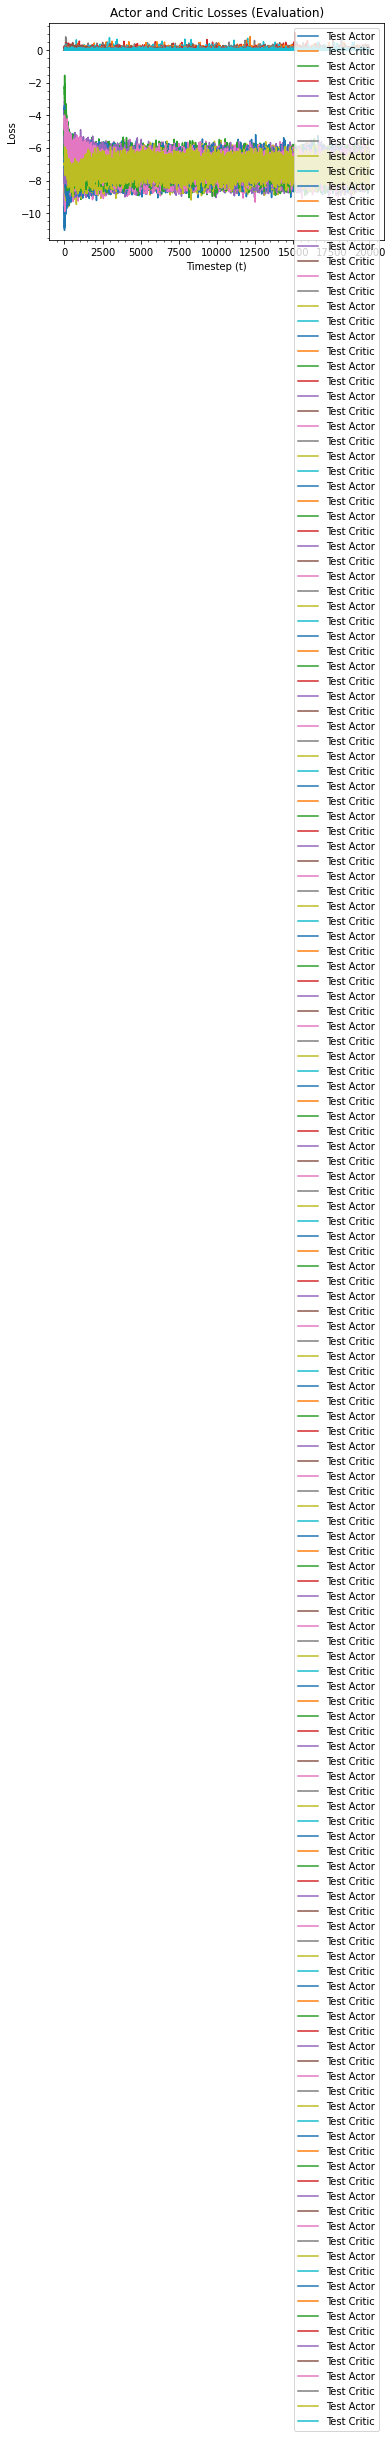

In [13]:
# Online evaluate
for T in Ts:
  avgs = []
  # Change T
  config.episode_length = T
  for i in range(20):
    # Evaluate
    avg_reward = trainer.online_evaluate()

    # Append data
    avgs.append(avg_reward)

  # Save data
  avgs = np.array(avgs)
  np.save(output_path + f'avg_reward@{T}_online_eval.npy', avgs)

  # Save
  sourceFile = open(output_path + f'avg_reward@{T}_online_eval.txt', 'w')
  print(f'Average Reward@{T} (Eval): {np.mean(avgs)}', file=sourceFile)
  sourceFile.close()

In [11]:
online_fives = np.load(output_path + 'avg_reward@5_online_eval.npy')
online_tens = np.load(output_path + 'avg_reward@10_online_eval.npy')
online_fifteens = np.load(output_path + 'avg_reward@15_online_eval.npy')
online_twenties = np.load(output_path + 'avg_reward@20_online_eval.npy')

[0.7283433133732535, 0.5597305389221556, 0.4586959414504325, 0.39991516966067864]
[0.009685473204837678, 0.006286593424695332, 0.007034322817827629, 0.006047300994932331]
[0.6004790419161676, 0.47524950099800395, 0.3987159015302728, 0.35545908183632735]
[0.011923103195026203, 0.006957741422081665, 0.006858484683346619, 0.006361608121239134]
[0.6151024659887101, 0.6543935402846713, 0.6478585222143289, 0.6347704487709687]
[0.004233648587640097, 0.008224257627721233, 0.007987935512709612, 0.008921825254856441]


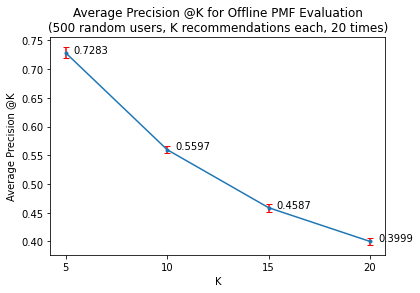

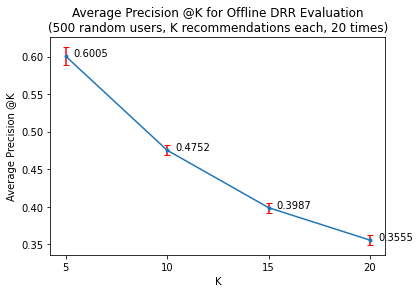

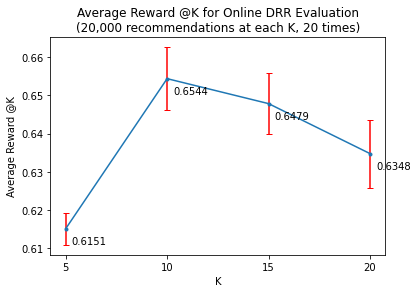

In [28]:
    # Evaluation @K Graphing

    def createEvalPlot(title, ylabel, xlabel, filename, x, y, e, e_x_off, e_y_off):
      plt.figure()
      plt.errorbar(x, y, yerr=e, fmt='.-', ecolor="red", capsize=3)
      plt.title(title)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.xticks(x)
      for i, j in zip(x, y):
          plt.annotate(str(round(j, 4)), xy=(i+e_x_off, j+e_y_off))
      plt.savefig(filename)

    # Combine data
    pmf_offline_eval_data = [pmf_fives, pmf_tens, pmf_fifteens, pmf_twenties]
    offline_eval_data = [drr_fives, drr_tens, drr_fifteens, drr_twenties]
    online_eval_data = [online_fives, online_tens, online_fifteens, online_twenties]

    # Calculate means and stds for graphing
    pmf_offline_means, pmf_offline_stds = [], []
    offline_means, offline_stds = [], []
    online_means, online_stds = [], []
    for d in pmf_offline_eval_data:
        pmf_offline_means.append(np.mean(d))
        pmf_offline_stds.append(np.std(d))

    for d in offline_eval_data:
        offline_means.append(np.mean(d))
        offline_stds.append(np.std(d))

    for d in online_eval_data:
        online_means.append(np.mean(d))
        online_stds.append(np.std(d))

    print(pmf_offline_means)
    print(pmf_offline_stds)
    print(offline_means)
    print(offline_stds)
    print(online_means)
    print(online_stds)


    # Create and save eval plots
    createEvalPlot("Average Precision @K for Offline PMF Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "pmf_offline_eval.png",
                   T_precisions,
                   pmf_offline_means,
                   pmf_offline_stds,
                   0.4,
                   0)

    createEvalPlot("Average Precision @K for Offline DRR Evaluation\n(500 random users, K recommendations each, 20 times)",
                   "Average Precision @K",
                   "K",
                   output_path + "offline_eval.png",
                   T_precisions,
                   offline_means,
                   offline_stds,
                   0.4,
                   0)

    createEvalPlot(
        "Average Reward @K for Online DRR Evaluation\n(20,000 recommendations at each K, 20 times)",
        "Average Reward @K",
        "K",
        output_path + "online_eval.png",
        Ts,
        online_means,
        online_stds,
        0.3,
        -0.004)